# CS 20 : TensorFlow for Deep Learning Research
## Lecture 5 : Variable sharing and managing experiments
### Word2vec (skip-gram) for simple example

- Creating the **input pipeline** with `tf.data`
- Creating the model as **Class**

Ref  
- https://github.com/golbin/TensorFlow-Tutorials/blob/master/04%20-%20Neural%20Network%20Basic/03%20-%20Word2Vec.py  
- https://github.com/aisolab/TF_code_examples_for_Deep_learning/blob/master/Tutorial%20of%20implementing%20Word2Vec.ipynb

### Setup

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import tensorflow as tf
%matplotlib inline

rc('font', family='AppleGothic')

print(tf.__version__)

1.8.0


### Data-preprocessing

In [2]:
# 단어 벡터를 분석해볼 임의의 문장들
sentences = ["나 고양이 좋다",
             "나 강아지 좋다",
             "나 동물 좋다",
             "강아지 고양이 동물",
             "여자친구 고양이 강아지 좋다",
             "고양이 생선 우유 좋다",
             "강아지 생선 싫다 우유 좋다",
             "강아지 고양이 눈 좋다",
             "나 여자친구 좋다",
             "여자친구 나 싫다",
             "여자친구 나 영화 책 음악 좋다",
             "나 게임 만화 애니 좋다",
             "고양이 강아지 싫다",
             "강아지 고양이 좋다"]

In [3]:
# 문장을 전부 합친 후, 공백으로 단어들을 나누고 고유한 단어들로 리스트를 만듭니다.
word_sequence = ' '.join(sentences).split()
word_list = list(set(word_sequence))
word_list.sort()
print(word_sequence)
print(word_list)

['나', '고양이', '좋다', '나', '강아지', '좋다', '나', '동물', '좋다', '강아지', '고양이', '동물', '여자친구', '고양이', '강아지', '좋다', '고양이', '생선', '우유', '좋다', '강아지', '생선', '싫다', '우유', '좋다', '강아지', '고양이', '눈', '좋다', '나', '여자친구', '좋다', '여자친구', '나', '싫다', '여자친구', '나', '영화', '책', '음악', '좋다', '나', '게임', '만화', '애니', '좋다', '고양이', '강아지', '싫다', '강아지', '고양이', '좋다']
['강아지', '게임', '고양이', '나', '눈', '동물', '만화', '생선', '싫다', '애니', '여자친구', '영화', '우유', '음악', '좋다', '책']


In [4]:
# 문자열로 분석하는 것 보다, 숫자로 분석하는 것이 훨씬 용이하므로
# 리스트에서 문자들의 인덱스를 뽑아서 사용하기 위해,
# 이를 표현하기 위한 연관 배열과, 단어 리스트에서 단어를 참조 할 수 있는 인덱스 배열을 만듭합니다.
word_dic = {w: i for i, w in enumerate(word_list)}
print(word_dic)

{'강아지': 0, '게임': 1, '고양이': 2, '나': 3, '눈': 4, '동물': 5, '만화': 6, '생선': 7, '싫다': 8, '애니': 9, '여자친구': 10, '영화': 11, '우유': 12, '음악': 13, '좋다': 14, '책': 15}


### Define preprocessor function for skip-gram of Word2Vec

In [5]:
def preprocessor(sequences, word_dic, window_size):
    context = []
    for idx in range(window_size, len(sequences) - window_size):
        center_word = word_dic.get(sequences[idx])
        context_words = [word_dic.get(sequences[idx + _]) for _ in range(-window_size, window_size + 1) if _ != 0]
    
        for token in context_words:
            context.append([center_word, token])
    else:
        return context

In [6]:
batch = preprocessor(sequences = word_sequence, word_dic = word_dic, window_size = 2)

In [7]:
center_words = np.array(batch)[:,0]
target_words = np.array(batch)[:,[1]]

### Define Word2vec class

In [8]:
class Word2vec:
    def __init__(self, center_words, target_words, vocab_size,
                embedding_dim = 2, num_sampled = 10):
        
        self._center_words = center_words
        self._target_words = target_words
        
        with tf.variable_scope('embeddings'):
            self._embeddings = tf.get_variable(name = 'lookup_table', shape = [vocab_size, embedding_dim],
                                               dtype = tf.float32, initializer = tf.truncated_normal_initializer())
            self._selected_embed = tf.nn.embedding_lookup(params = self._embeddings, ids = self._center_words)
            

        with tf.variable_scope('nce'):
            nce_weights = tf.get_variable('weights', shape = [vocab_size, embedding_dim], dtype = tf.float32,
                                         initializer = tf.truncated_normal_initializer())
            nce_biases = tf.get_variable('biases', initializer = tf.zeros(shape = [vocab_size]))
            
            self.nce_loss = tf.reduce_mean(tf.nn.nce_loss(weights = nce_weights, biases = nce_biases,
                                            labels = self._target_words, inputs = self._selected_embed,
                                            num_sampled = num_sampled, num_classes = vocab_size))
    
    def get_wordvector(self, sess, word_dic, word):
        idx = word_dic.get(word)
        feed_get_wordvector = {self._center_words : [idx]}
        return sess.run(self._selected_embed, feed_dict = feed_get_wordvector)

### Create a model of Word2vec

In [9]:
# hyper-parameter
epochs = 200
batch_size = 8
learning_rate = .001
total_step = int(len(batch) / batch_size)
print(total_step)

24


In [10]:
## create input pipeline with tf.data
dataset = tf.data.Dataset.from_tensor_slices((center_words, target_words))
dataset = dataset.shuffle(buffer_size = 32)
dataset = dataset.batch(batch_size = batch_size)
iterator = dataset.make_initializable_iterator()
x_data, y_data = iterator.get_next()

In [11]:
sgram = Word2vec(center_words = x_data, target_words = y_data, vocab_size = len(word_dic))

### Create training op and train model 

In [12]:
# create training op
opt = tf.train.AdamOptimizer(learning_rate = learning_rate)

# equal to 'var_list = None'
training_op = opt.minimize(loss = sgram.nce_loss)

In [13]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

tr_loss_hist = []

for epoch in range(epochs):
    sess.run(iterator.initializer)
    avg_tr_loss = 0
    total_step = 0

    try:
        while True:
            _, tr_loss = sess.run(fetches = [training_op, sgram.nce_loss])
            avg_tr_loss += tr_loss
            total_step += 1

    except tf.errors.OutOfRangeError:
        pass
    
    avg_tr_loss /= total_step
    tr_loss_hist.append(avg_tr_loss)
    
    if epoch % 20 == 0:
        print('epoch : {:3}, tr_loss : {:.2f}'.format(epoch, avg_tr_loss))

epoch :   0, tr_loss : 10.58
epoch :  20, tr_loss : 7.72
epoch :  40, tr_loss : 5.30
epoch :  60, tr_loss : 4.20
epoch :  80, tr_loss : 3.66
epoch : 100, tr_loss : 3.36
epoch : 120, tr_loss : 3.25
epoch : 140, tr_loss : 3.29
epoch : 160, tr_loss : 3.12
epoch : 180, tr_loss : 3.10


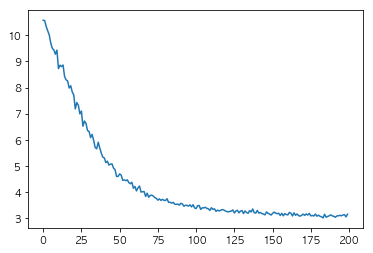

In [14]:
plt.plot(tr_loss_hist)

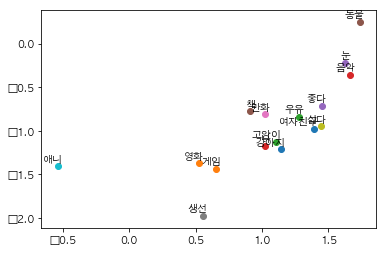

In [15]:
for word in word_list:
    tmp = sgram.get_wordvector(sess = sess, word_dic = word_dic, word = word)
    x, y = tmp[0][0], tmp[0][1]
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2),
                 textcoords='offset points', ha='right', va='bottom')